# Deep Learning Project

## Final report

## Study of the impact on the ratio of unlabeled to labeled data on top-1 accuracy on the CIFAR-10 dataset and House Numbers dataset

Pierre Andurand (pa2570)
Tzu Yi Chuang (tc3075)
Kuan Yu Ko (kk3376)

In [10]:
# Resnet for CIFAR10 taken from Keras https://keras.io/examples/cifar10_resnet/



import matplotlib.pyplot as plt
import tensorflow as tf
# limit GPU memory to stop kernel crash
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
layers = tf.keras.layers
import numpy as np
print(tf.__version__)
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Dropout
import matplotlib.pyplot as plt
import os


def prepare_cifar10_data(subtract_pixel_mean = True):
    
    # The data, split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    num_classes=10
    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

    
def prepare_house_numbers_data(subtract_pixel_mean = True):
    ## We import housenumber dataset from http://ufldl.stanford.edu/housenumbers/

    #Loading dataset
    num_classes=10
    from scipy.io import loadmat

    train = loadmat('train_32x32.mat')
    test = loadmat('test_32x32.mat')

    # train and test are python dictionaries
    # keys are ['__header__', '__version__', '__globals__', 'X', 'y']

    x_train = train['X']
    y_train = train['y']
    x_test = test['X']
    y_test = test['y']

    # x and y are numpy ndarrays

    print("Shape of x_train is:", x_train.shape)
    print("Shape of y_train is:", y_train.shape)
    print("Shape of x_test is:", x_test.shape)
    print("Shape of y_test is:", y_test.shape)

    x_train = x_train[:,:,:,:]
    x_test = x_test[:,:,:,:]

    x_train = np.rollaxis(x_train, 3)
    x_test = np.rollaxis(x_test, 3)

    print("Shape of x_train is now:", x_train.shape)
    print("Shape of x_test is now:", x_test.shape)

    y_train = y_train[:,0]
    y_test = y_test[:,0]

    print("Shape of y_train is now:", y_train.shape)
    print("Shape of y_test is now:", y_test.shape)

    y_train[y_train==10] = 0
    y_test[y_test==10] = 0

    print("labels of y_train are", np.unique(y_train[:]))
    print("labels of y_test are", np.unique(y_test[:]))
    
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

#Defining Resnet20 model




# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------






def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




def choose_resnet_model(input_shape, n=3, version=1):
    
    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)


    # Input image dimensions.
    #input_shape = x_train.shape[1:]

    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    init = model.get_weights()

    return model, init, model_type
    

def train_model(init, model, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, data_augmentation=True, 
                model_name= 'keras_cifar10_trained_teacher.h5'):
    
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    model.set_weights(init)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]

    if not data_augmentation:
        print("Not using data augmentation.")
        model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test,y_test),
                    shuffle=True,
                    callbacks=callbacks)

    else:
        # This will do preprocessing and realtime data augmentation:
        print("Using real-time data augmentation.")
        datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # epsilon for ZCA whitening
                zca_epsilon=1e-06,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # set range for random shear
                shear_range=0.,
                # set range for random zoom
                zoom_range=0.,
                # set range for random channel shifts
                channel_shift_range=0.,
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                # value used for fill_mode = "constant"
                cval=0.,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False,
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.0)

        datagen.fit(x_train)

        # Fit the noised student model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs, verbose=1, workers=4,validation_data=(x_test,y_test),
                                callbacks=callbacks)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Supervised learning model with '+str(epochs)+'epochs \n')
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    
    # Save model and weights
    model.save(filepath)
    print('Saved trained model at %s ' % filepath)

    return scores[1], filepath




2 Physical GPUs, 2 Logical GPUs
2.1.0


 
# Test 1
Below we would like to check if starting from the weights of the fully supervised model trained above, we would get an increase in accuracy if we run STNS on the full dataset with different ratios of unlabeled to labeled data. And if the accuracy goes up, we would like to see what is the optimal ratio. 
The STNS algorithm used is as follows:
We do a loop over different ratios of label to unlabelled data (rate). And each loop does the following:
1) take the weights from the fully supervised teacher model trained in box above 
2) Ten cycles of: un-noised model (teacher)->predict hard pseudolabel->training 10 epochs for noised model (student=teacher+dropout noise) on labeled+pseudo labeled->new weights. 

The student model will be the teacher model noised by a Dropout(0.5) before the last layer. And we will use data augmentation to add to the noise for the student model

In [2]:
#Defining noised Student with a Dropout(0.5) just before the output layer


def noised_resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def noised_resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def choose_noised_resnet_model(input_shape, n=3, version=1):

    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    if version == 2:
        model = noised_resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = noised_resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    
    print(model_type)
    
    return model 








In [22]:
def stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, data_augmentation):
    
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    teacher_loop_name = 'keras_teacher_loop.h5'
    teacher_loop_path = os.path.join(save_dir, teacher_loop_name)
    num_classes=10

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # epsilon for ZCA whitening
                zca_epsilon=1e-06,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # set range for random shear
                shear_range=0.,
                # set range for random zoom
                zoom_range=0.,
                # set range for random channel shifts
                channel_shift_range=0.,
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                # value used for fill_mode = "constant"
                cval=0.,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False,
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.0)
    
    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=teacher_path,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]
    
    # rate= n_true/n_pseudo
    
    n_total=x_train.shape[0]

    # total number of train images (n_total) = number of true label images (n_true) + number of pseudo label images (n_pseudo)
    #                                        = n_pseudo(1/rate+1)
    # n_pseudo = n_total/(1/rate+1); n_true=n_total-n_pseudo

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    j=0
    accuracy=np.zeros(rate.shape[0])
    for r in rate:
    
        print("rate="+str(r)+":\n")
        n_pseudo=n_total/(1+(1/r))
        n_true=n_total-n_pseudo
        mask_true=np.random.choice(int(n_total),int(n_true),replace=False) #generating n_true integers between 0 and n_total-1
        mask_pseudo=[item for item in range(n_total) if item not in mask_true] #all the other numbers between 0 and n_total-1 which are not in mask_true
        mask_pseudo=np.array(mask_pseudo)
        x_true=x_train[mask_true[:]] #x for the labeled data
        y_true=y_train[mask_true[:]] #y for the labeled data
        x_pseudo=x_train[mask_pseudo[:]] #x for the unlabeled data (pseudo)
        #Taking weights from supervised model on full data (box above) 
        teacher.load_weights(teacher_path)
        teacher.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
        #evaluating teacher model on test data    
        scores=teacher.evaluate(x_test,y_test,verbose=0)
        print("Original model with labelled data only predicting on test data: ",scores[1])

        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        y_pseudo = y_pseudo.argmax(axis=-1)
        y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
        print('Shape y_pseudo',y_pseudo.shape)
        print('Shape y_true',y_true.shape)
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        student.load_weights(teacher_path)
        for i in range(10): 
            # 10 loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)
            print(i)
            # Compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            datagen.fit(x_true_pseudo)

            # Fit the noised student model on the batches generated by datagen.flow().
            training=student.fit_generator(datagen.flow(x_true_pseudo, y_true_pseudo, batch_size=32),
                            epochs=10, verbose=1, workers=4,validation_data=(x_test,y_test),
                            callbacks=callbacks)

            # Save weights
            student.save_weights(teacher_loop_path)
            # Load weights for teacher model (un-noised)
            teacher.load_weights(teacher_loop_path)
            y_pseudo=teacher.predict(x_pseudo)
            y_pseudo = y_pseudo.argmax(axis=-1)
            scores=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores[0])
            print('Test accuracy:', scores[1])

            y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
        accuracy[j]=scores[1]
        j+=1

    supervised=[accuracy_supervised for i in range(len(rate))]
    plt.plot(rate,accuracy)
    plt.plot(rate,supervised,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Resnet - Test1 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Resnet - Test1 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy

# Test 2
Now, we take a subset of 5,000 pictures that we use as labeled, and use part of the rest of the dataset as unlabeled. We run the teacher model on that labeled dataset. And then run STNS. We do that for different rate levels, and compare accuracies
And then we try for a subset of 1000 pictures.

In [5]:
# Varying the ratio for 5000 or 1000 labeled images. Rest of training dataset unlabeled with ratio determining size of total dataset.
# Testing on full test dataset



def prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=10):

    total_size_cifar10=x_train.shape[0]   
    print(total_size_cifar10)
    print(y_train.shape)
    y_train=y_train.argmax(axis=-1)
    print(y_train.shape)
    #checking that classes are balanced
    for i in range(num_classes):
        print(str(i)+":",sum(y_train==i))

    #Selecting 500 images of each class
    k=0
    x_true=np.zeros((sample_size,32,32,3))
    y_true=np.full((sample_size,),-1)
    mask2=[]
    for i in range(total_size_cifar10):
        #print(i)
        for j in range(num_classes):
            if sum(y_true==j)<sample_size/num_classes:
                if y_train[i]==j:
                    x_true[k,:]=x_train[i,:]
                    y_true[k]=y_train[i]
                    k+=1
                    mask2.append(i)
                    break
        #print('k=',k)
        if k==sample_size:
            break
        
    #print(y_small_train[0:40])
    print(x_true.shape)
    print(y_true.shape)


    #verifying that there are 500 images in each class
    for i in range(num_classes):
        print(str(i)+":",sum(y_true==i))
    
    y_true=keras.utils.to_categorical(y_true, 10)
    
    return x_true, y_true, mask2
 
def stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, epochs=100, 
              data_augmentation=True):
    
    total_size_cifar10=x_train.shape[0]
    num_classes=10
    x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size, num_classes=num_classes)
    
    accuracy2_supervised, teacher2_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, 
                                                       epochs=epochs, data_augmentation=data_augmentation,
                                                       model_name= model_name)

    print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
    print('Test accuracy:', accuracy2_supervised)
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    teacher_loop2_name = 'teacher_loop2.h5'
    teacher_loop2_path = os.path.join(save_dir, teacher_loop2_name)

    
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
    
    
    
    
    
    mask3=[i for i in range(total_size_cifar10) if i not in mask2]
    x_total_unlabeled=x_train[mask3,:]
    print("size x_total_unlabeled (should be 45,000): ", x_total_unlabeled.shape[0])
    
    # rate= n_true/n_pseudo, n_true=sample_size

    number_rate=len(rate)
    
    #n_total=sample_size*(1+rate)

    # total number of train images (n_total) = number of true label images (sample_size) + number of pseudo label images (n_pseudo)
    #                                        = sample_size(rate+1)
    # n_pseudo = sample_size*rate

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    
    accuracy2=np.zeros(number_rate)
    j=0
    for r in rate:
    
        teacher.load_weights(teacher2_path)
        student.load_weights(teacher2_path)
    
        print("rate="+str(r)+":\n")
        n_pseudo=int(sample_size*r)
        n_true=sample_size
        n_total=n_true+n_pseudo
        print("n_total, n_true, n_pseudo: ", n_total, n_true, n_pseudo)
        x_pseudo=x_total_unlabeled[0:n_pseudo,:] #x for the unlabeled data (pseudo)
        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        y_pseudo = y_pseudo.argmax(axis=-1)
        y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        for i in range(10): 
            # 10 loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)
            print(i)
            training=student.fit(x_true_pseudo,y_true_pseudo,validation_data=(x_test,y_test),
                                 epochs=10,batch_size=32,verbose=0)
            # Save weights
            student.save_weights(teacher_loop2_path)
            # Load weights for teacher model (un-noised)
            teacher.load_weights(teacher_loop2_path)
            y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
            y_pseudo = y_pseudo.argmax(axis=-1)
            y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
            scores3=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores3[0])
            print('Test accuracy:', scores3[1])
            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
    
        accuracy2[j]=scores3[1]
        j+=1

    supervised2=[accuracy2_supervised for i in range(number_rate)]
    plt.plot(rate, accuracy2)
    plt.plot(rate, supervised2,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Resnet - Test2 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Resnet  - Test2 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy2
    
    
    
#from keras.utils import plot_model
#plot_model(teacher,to_file='teacher.png')
#plot_model(student,to_file='student.png')

In [ ]:
#### Run all the definitions above, and then run the calculations in following boxes

#Running Test2 for CIFAR10

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate2=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5])
model_name= 'keras_cifar10_trained_teacher_5000_da.h5'
accuracy_2 = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate2,teacher,
                      student, sample_size=5000, epochs=100, 
                      data_augmentation=True)

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(1000, 32, 32, 3)
(1000,)
0: 100
1: 100
2: 100
3: 100
4: 100
5: 100
6: 100
7: 100
8: 100
9: 100
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
32/32 [==============================] - 12s 390ms/step - loss: 2.6404 - accuracy: 0.1840 - val_loss: 2.4599 - val_accuracy: 0.1887
Epoch 2/100
Learning rate:  0.001
 3/32 [=>............................] - ETA: 1s - loss: 2.1433 - accuracy: 0.2812

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


32/32 [==============================] - 5s 154ms/step - loss: 2.0267 - accuracy: 0.3230 - val_loss: 2.3648 - val_accuracy: 0.1519
Epoch 3/100
Learning rate:  0.001
32/32 [==============================] - 5s 154ms/step - loss: 1.9217 - accuracy: 0.3500 - val_loss: 2.4143 - val_accuracy: 0.2190
Epoch 4/100
Learning rate:  0.001
32/32 [==============================] - 5s 153ms/step - loss: 1.8670 - accuracy: 0.3580 - val_loss: 2.3642 - val_accuracy: 0.2183
Epoch 5/100
Learning rate:  0.001
32/32 [==============================] - 5s 153ms/step - loss: 1.7718 - accuracy: 0.4170 - val_loss: 2.8085 - val_accuracy: 0.1931
Epoch 6/100
Learning rate:  0.001
32/32 [==============================] - 5s 151ms/step - loss: 1.7042 - accuracy: 0.4290 - val_loss: 2.9160 - val_accuracy: 0.2171
Epoch 7/100
Learning rate:  0.001
32/32 [==============================] - 5s 151ms/step - loss: 1.6587 - accuracy: 0.4480 - val_loss: 2.3966 - val_accuracy: 0.2327
Epoch 8/100
Learning rate:  0.001
32/32 [===

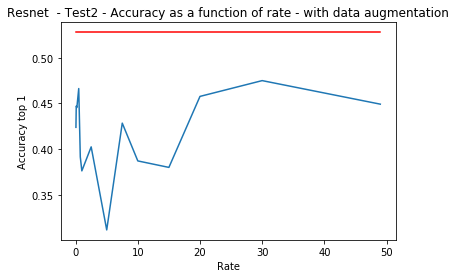

In [7]:
#Running Test2 for CIFAR10


(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate10=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,10,15,20,30,49])
model_name= 'keras_cifar10_trained_teacher_1000_da.h5'
accuracy_10 = stns_5000(init,model_name,x_train,y_train,x_test,y_test,rate10,teacher,
                       student, sample_size=1000, epochs=100,
                       data_augmentation=True)

In [ ]:
#Running Test2 for CIFAR10

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate3=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
model_name= 'keras_cifar10_trained_teacher_5000_nda.h5'
accuracy_3 = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate3,teacher, student, sample_size=5000, epochs=100,
                      data_augmentation=False)

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(1000, 32, 32, 3)
(1000,)
0: 100
1: 100
2: 100
3: 100
4: 100
5: 100
6: 100
7: 100
8: 100
9: 100
Learning rate:  0.001
Not using data augmentation.
Train on 1000 samples, validate on 10000 samples
Epoch 1/100
Learning rate:  0.001
1000/1000 [==============================] - 11s 11ms/step - loss: 2.5307 - accuracy: 0.2100 - val_loss: 2.4702 - val_accuracy: 0.1903
Epoch 2/100
Learning rate:  0.001
 160/1000 [===>..........................] - ETA: 1s - loss: 1.9660 - accuracy: 0.3187

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1000/1000 [==============================] - 5s 5ms/step - loss: 1.8598 - accuracy: 0.3670 - val_loss: 2.2779 - val_accuracy: 0.2193
Epoch 3/100
Learning rate:  0.001
1000/1000 [==============================] - 5s 5ms/step - loss: 1.6578 - accuracy: 0.4680 - val_loss: 2.8549 - val_accuracy: 0.1821
Epoch 4/100
Learning rate:  0.001
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3970 - accuracy: 0.5670 - val_loss: 2.3334 - val_accuracy: 0.2442
Epoch 5/100
Learning rate:  0.001
1000/1000 [==============================] - 5s 5ms/step - loss: 1.1043 - accuracy: 0.7100 - val_loss: 2.9942 - val_accuracy: 0.2216
Epoch 6/100
Learning rate:  0.001
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9137 - accuracy: 0.7480 - val_loss: 3.1029 - val_accuracy: 0.2133
Epoch 7/100
Learning rate:  0.001
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7673 - accuracy: 0.8010 - val_loss: 3.9440 - val_accuracy: 0.2292
Epoch 8/100
Learning rate:  0.00

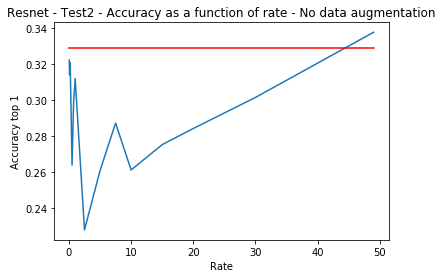

In [8]:
#Running Test2 for CIFAR10

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate11=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,10,15,20,30,49])
model_name= 'keras_cifar10_trained_teacher_1000_nda.h5'
accuracy_11 = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate11,teacher, student, sample_size=1000, epochs=100,
                       data_augmentation=False)

In [ ]:
#Running Test2 for HouseNumbers

(x_train_house,y_train_house),(x_test_house,y_test_house) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate4=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
model_name= 'keras_HN_trained_teacher_5000_da.h5'
accuracy_4 = stns_5000(init, model_name, x_train_house,y_train_house,x_test_house,y_test_house,rate4,teacher, student, sample_size=5000, 
                      epochs=100,
                      data_augmentation=True)

In [ ]:
#Running Test2 for HouseNumbers

(x_train_house,y_train_house),(x_test_house,y_test_house) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate12=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,10,15,20,30,49])
model_name= 'keras_HN_trained_teacher_1000_da.h5'
accuracy_12 = stns_5000(init, model_name, x_train_house,y_train_house,x_test_house,y_test_house,rate12,teacher, student, sample_size=1000,
                       epochs=100,
                      data_augmentation=True )

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Not using data augmentation.
Train on 5000 samples, validate on 26032 samples
Epoch 1/100
Learning rate:  0.001
5000/5000 [==============================] - 22s 4ms/step - loss: 2.4486 - accuracy: 0.1850 - val_loss: 2.4188 - val_accuracy: 0.2140
Epoch 2/100
Learning rate:  0.001
  96/5000 [..............................] - ETA: 6s - 

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


5000/5000 [==============================] - 16s 3ms/step - loss: 1.5969 - accuracy: 0.5212 - val_loss: 1.7052 - val_accuracy: 0.4892
Epoch 3/100
Learning rate:  0.001
5000/5000 [==============================] - 16s 3ms/step - loss: 1.0012 - accuracy: 0.7366 - val_loss: 1.3873 - val_accuracy: 0.6015
Epoch 4/100
Learning rate:  0.001
5000/5000 [==============================] - 16s 3ms/step - loss: 0.7325 - accuracy: 0.8242 - val_loss: 1.0914 - val_accuracy: 0.7124
Epoch 5/100
Learning rate:  0.001
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5937 - accuracy: 0.8702 - val_loss: 1.2004 - val_accuracy: 0.6822
Epoch 6/100
Learning rate:  0.001
5000/5000 [==============================] - 15s 3ms/step - loss: 0.4911 - accuracy: 0.8990 - val_loss: 0.8001 - val_accuracy: 0.7956
Epoch 7/100
Learning rate:  0.001
5000/5000 [==============================] - 15s 3ms/step - loss: 0.4151 - accuracy: 0.9226 - val_loss: 1.0075 - val_accuracy: 0.7367
Epoch 8/100
Learning rate:

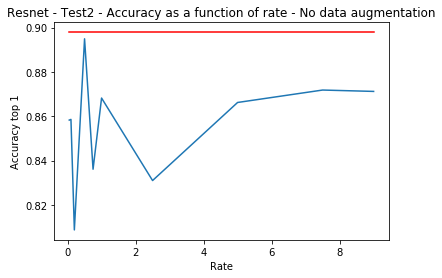

In [11]:
#Running Test2 for HouseNumbers

(x_train_house,y_train_house),(x_test_house,y_test_house) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate5=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
model_name= 'keras_HN_trained_teacher_5000_nda.h5'
accuracy_5 = stns_5000(init, model_name, x_train_house,y_train_house,x_test_house,y_test_house,rate5,teacher, student, sample_size=5000, epochs=100,
                      data_augmentation=False )

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(1000, 32, 32, 3)
(1000,)
0: 100
1: 100
2: 100
3: 100
4: 100
5: 100
6: 100
7: 100
8: 100
9: 100
Learning rate:  0.001
Not using data augmentation.
Train on 1000 samples, validate on 26032 samples
Epoch 1/100
Learning rate:  0.001
1000/1000 [==============================] - 17s 17ms/step - loss: 2.7511 - accuracy: 0.0930 - val_loss: 2.4455 - val_accuracy: 0.1545
Epoch 2/100
Learning rate:  0.001
  96/1000 [=>............................] - ETA: 1s -

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1000/1000 [==============================] - 10s 10ms/step - loss: 2.4538 - accuracy: 0.1420 - val_loss: 2.4786 - val_accuracy: 0.0821
Epoch 3/100
Learning rate:  0.001
1000/1000 [==============================] - 11s 11ms/step - loss: 2.2502 - accuracy: 0.2510 - val_loss: 2.6539 - val_accuracy: 0.1723
Epoch 4/100
Learning rate:  0.001
1000/1000 [==============================] - 11s 11ms/step - loss: 2.0482 - accuracy: 0.3360 - val_loss: 2.7640 - val_accuracy: 0.1335
Epoch 5/100
Learning rate:  0.001
1000/1000 [==============================] - 11s 11ms/step - loss: 1.8028 - accuracy: 0.4200 - val_loss: 2.8322 - val_accuracy: 0.2167
Epoch 6/100
Learning rate:  0.001
1000/1000 [==============================] - 11s 11ms/step - loss: 1.5052 - accuracy: 0.5610 - val_loss: 5.4410 - val_accuracy: 0.1042
Epoch 7/100
Learning rate:  0.001
1000/1000 [==============================] - 10s 10ms/step - loss: 1.3047 - accuracy: 0.6100 - val_loss: 5.4787 - val_accuracy: 0.2068
Epoch 8/100
Learning

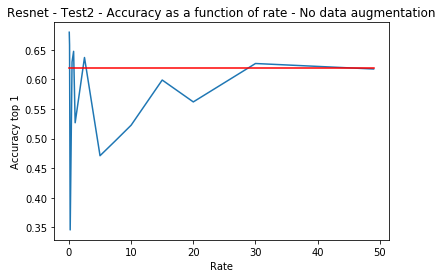

In [12]:
#Running Test2 for HouseNumbers

(x_train_house,y_train_house),(x_test_house,y_test_house) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate13=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,10,15,20,30,49])
model_name= 'keras_HN_trained_teacher_1000_nda.h5'
accuracy_13 = stns_5000(init, model_name, x_train_house,y_train_house,x_test_house,y_test_house,rate13,teacher, student, sample_size=1000, 
                       epochs=100,
                      data_augmentation=False)

In [ ]:
#Test1
#Restnet20 on full CIFAR10 train dataset with data augmentation

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                                  data_augmentation=True, model_name= 'keras_cifar10_trained_teacher_da.h5')

rate6=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
accuracy_6=stns_full_dataset(x_train,y_train,x_test,y_test,rate6,teacher, student,teacher_path,accuracy_supervised, data_augmentation=True)

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
Learning rate:  0.001
50000/50000 [==============================] - 73s 1ms/step - loss: 1.4791 - accuracy: 0.5225 - val_loss: 1.4291 - val_accuracy: 0.5355
Epoch 2/100
Learning rate:  0.001
   96/50000 [..............................] - ETA: 1:04 - loss: 1.0557 - accuracy: 0.6562

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50000/50000 [==============================] - 68s 1ms/step - loss: 1.0596 - accuracy: 0.6831 - val_loss: 1.1484 - val_accuracy: 0.6573
Epoch 3/100
Learning rate:  0.001
50000/50000 [==============================] - 65s 1ms/step - loss: 0.8938 - accuracy: 0.7456 - val_loss: 1.2904 - val_accuracy: 0.6324
Epoch 4/100
Learning rate:  0.001
50000/50000 [==============================] - 67s 1ms/step - loss: 0.8016 - accuracy: 0.7800 - val_loss: 1.1302 - val_accuracy: 0.6981
Epoch 5/100
Learning rate:  0.001
50000/50000 [==============================] - 66s 1ms/step - loss: 0.7288 - accuracy: 0.8077 - val_loss: 0.9043 - val_accuracy: 0.7547
Epoch 6/100
Learning rate:  0.001
50000/50000 [==============================] - 67s 1ms/step - loss: 0.6790 - accuracy: 0.8278 - val_loss: 0.8182 - val_accuracy: 0.7854
Epoch 7/100
Learning rate:  0.001
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6402 - accuracy: 0.8427 - val_loss: 1.0553 - val_accuracy: 0.7187
Epoch 8/100
Le

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1563/1563 [==============================] - 69s 44ms/step - loss: 0.8430 - accuracy: 0.7769 - val_loss: 0.6990 - val_accuracy: 0.8212
Epoch 3/10
Learning rate:  0.001
1563/1563 [==============================] - 69s 44ms/step - loss: 0.7992 - accuracy: 0.7945 - val_loss: 0.8312 - val_accuracy: 0.7784
Epoch 4/10
Learning rate:  0.001
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7767 - accuracy: 0.8053 - val_loss: 0.7501 - val_accuracy: 0.8072
Epoch 5/10
Learning rate:  0.001
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7650 - accuracy: 0.8122 - val_loss: 0.8185 - val_accuracy: 0.8060
Epoch 6/10
Learning rate:  0.001
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7551 - accuracy: 0.8191 - val_loss: 0.7641 - val_accuracy: 0.8140
Epoch 7/10
Learning rate:  0.001
1563/1563 [==============================] - 69s 44ms/step - loss: 0.7322 - accuracy: 0.8293 - val_loss: 0.7768 - val_accuracy: 0.8094
Epoch 8/10
Learning rate:

NameError: name 'data_augmentation' is not defined

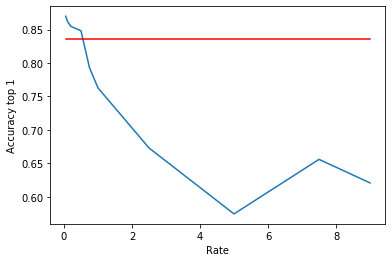

In [21]:
#Test1
#Restnet20 on full CIFAR10 train dataset without data augmentation

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                                  data_augmentation=False, model_name= 'keras_cifar10_trained_teacher_nda.h5')

rate7=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
accuracy_7=stns_full_dataset(x_train,y_train,x_test,y_test,rate7,teacher, student,teacher_path,accuracy_supervised, data_augmentation=False)

In [ ]:
#Test1
#Restnet20 on full House numbers train dataset with data augmentation

(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                                  data_augmentation=True, model_name= 'keras_housenumbers_trained_teacher_da.h5')

rate8=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
accuracy_8=stns_full_dataset(x_train,y_train,x_test,y_test,rate8,teacher, student,teacher_path,accuracy_supervised, data_augmentation=True)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Not using data augmentation.
Train on 73257 samples, validate on 26032 samples
Epoch 1/100
Learning rate:  0.001
73257/73257 [==============================] - 106s 1ms/step - loss: 0.8105 - accuracy: 0.7892 - val_loss: 0.5988 - val_accuracy: 0.8658
Epoch 2/100
Learning rate:  0.001
  160/73257 [..............................] - ETA: 1:29 - loss: 0.4245 - accuracy: 0.9125

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


73257/73257 [==============================] - 101s 1ms/step - loss: 0.4358 - accuracy: 0.9140 - val_loss: 0.4961 - val_accuracy: 0.8917
Epoch 3/100
Learning rate:  0.001
73257/73257 [==============================] - 101s 1ms/step - loss: 0.3889 - accuracy: 0.9262 - val_loss: 0.6137 - val_accuracy: 0.8504
Epoch 4/100
Learning rate:  0.001
73257/73257 [==============================] - 100s 1ms/step - loss: 0.3611 - accuracy: 0.9339 - val_loss: 0.3491 - val_accuracy: 0.9363
Epoch 5/100
Learning rate:  0.001
73257/73257 [==============================] - 100s 1ms/step - loss: 0.3401 - accuracy: 0.9381 - val_loss: 0.4580 - val_accuracy: 0.9034
Epoch 6/100
Learning rate:  0.001
73257/73257 [==============================] - 102s 1ms/step - loss: 0.3245 - accuracy: 0.9421 - val_loss: 0.3469 - val_accuracy: 0.9373
Epoch 7/100
Learning rate:  0.001
73257/73257 [==============================] - 101s 1ms/step - loss: 0.3157 - accuracy: 0.9456 - val_loss: 0.4070 - val_accuracy: 0.9159
Epoch 8/

/home/ANDURAND/pandurand/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2290/2290 [==============================] - 105s 46ms/step - loss: 0.4593 - accuracy: 0.8936 - val_loss: 0.3239 - val_accuracy: 0.9325
Epoch 3/10
Learning rate:  0.001
2290/2290 [==============================] - 106s 46ms/step - loss: 0.4431 - accuracy: 0.9032 - val_loss: 0.3284 - val_accuracy: 0.9310
Epoch 4/10
Learning rate:  0.001
2290/2290 [==============================] - 106s 46ms/step - loss: 0.4312 - accuracy: 0.9082 - val_loss: 0.3424 - val_accuracy: 0.9309
Epoch 5/10
Learning rate:  0.001
2290/2290 [==============================] - 106s 46ms/step - loss: 0.4185 - accuracy: 0.9122 - val_loss: 0.3508 - val_accuracy: 0.9317
Epoch 6/10
Learning rate:  0.001
2290/2290 [==============================] - 106s 46ms/step - loss: 0.4163 - accuracy: 0.9171 - val_loss: 0.3546 - val_accuracy: 0.9320
Epoch 7/10
Learning rate:  0.001
2290/2290 [==============================] - 106s 46ms/step - loss: 0.4122 - accuracy: 0.9180 - val_loss: 0.3503 - val_accuracy: 0.9374
Epoch 8/10
Learning

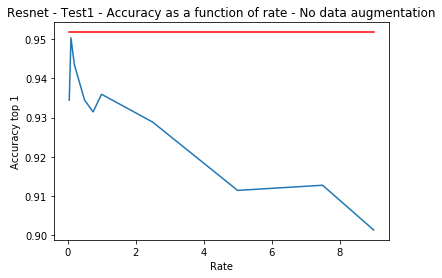

In [23]:
#Test1
#Restnet20 on full House numbers train dataset without data augmentation

(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                                  data_augmentation=False, model_name= 'keras_housenumbers_trained_teacher_nda.h5')

rate9=np.array([0.05,0.1,0.2,0.5,0.75,1,2.5,5,7.5,9])
accuracy_9=stns_full_dataset(x_train,y_train,x_test,y_test,rate9,teacher, student,teacher_path,accuracy_supervised, data_augmentation=False)